In [1]:
! which python3
! python3 -V

/home/mykmur/dev/venv/bin/python3
Python 3.8.15


In [2]:
import typing as t
import jax.numpy as jnp
import pandas as pd
import metadata
import haiku as hk
import utils
import jax
import optax
import random
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_debug_nans", True)

### Statics

In [3]:
BLOCK_SIZE = int(24*60/5) # 2 days
BATCH_SIZE = 8
SPLIT = 0.85
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-4
SEED = 2137
NUM_TRAINING_STEPS = 300
EVAL_INTERVAL = 10
FEATURE_NUM = 1

### Load data

In [4]:
class DataLoader:
    def __init__(self, data_path: str):
        self.df = pd.read_pickle(data_path)

        _map = metadata.NODE_IDS_TO_LABELS_MAPPING
        self.edges_to_samples_mapping = {}

        for x, row in enumerate(metadata.ADJACENCY_MATRIX):
            for y, _ in enumerate(row):

                if metadata.ADJACENCY_MATRIX[x][y]:
                    self.edges_to_samples_mapping[(_map[x], _map[y])] = \
                        self.get_data_for_link(_map[x], _map[y])

        _b = BLOCK_SIZE*BATCH_SIZE
        # all the sample array are equal size, so it doesn't matter which one we choose
        num_subsets = (self.edges_to_samples_mapping[('uci', 'ftj')].shape[0] - 1) // _b
        cutoff_num = (self.edges_to_samples_mapping[('uci', 'ftj')].shape[0] - 1) % _b
        split_idx = int(SPLIT * num_subsets)

        # collect metadata
        self.metadata = {
            k: {'mean': samples.mean(), 'std': samples.std()}
            for k, samples in self.edges_to_samples_mapping.items()
        }

        #  encode & normalize the data
        self.edges_to_samples_mapping = {
            k: self.normalize(self.encode(samples))
            for k, samples in self.edges_to_samples_mapping.items()
        }

        #  input/target split
        self.edges_to_samples_mapping = {
            k: {'input': samples[:-1], 'target': samples[1:]}
            for k, samples in self.edges_to_samples_mapping.items()
        }

        #  rounding to batchable size & pre-batching
        self.edges_to_samples_mapping = {
            k: {
                'input': jnp.reshape(samples['input'][:-cutoff_num], (num_subsets, BATCH_SIZE, BLOCK_SIZE, 1)),
                'target': jnp.reshape(samples['target'][:-cutoff_num], (num_subsets, BATCH_SIZE, BLOCK_SIZE, 1))
            } for k, samples in self.edges_to_samples_mapping.items()
        }

        #  batching
        self.edges_to_samples_mapping = {
            k: [
                {
                    'input': samples['input'][idx], 'target': samples['target'][idx]
                } for idx in range(samples['input'].shape[0])
            ] for k, samples in self.edges_to_samples_mapping.items()
        }

        self.train_ds = {
            k: samples[:split_idx] for k, samples in self.edges_to_samples_mapping.items()
        }
        self.test_ds = {
            k: samples[split_idx:] for k, samples in self.edges_to_samples_mapping.items()
        }
        self.unified_train_ds = [sample for _, samples in self.train_ds.items() for sample in samples]

    class DataIter:
        def __init__(self, data):
            self.edge_data = data

        def __next__(self):
            return random.choice(self.edge_data)

    def get_edge_data_iterator(self, src: str, dst: str, train=True, all=True):
        if train:
            if all:
                data = self.unified_train_ds
            else:
                data = self.train_ds[(src, dst)]
        else:
            data = self.test_ds[(src, dst)]
        return self.DataIter(data)

    @staticmethod
    def encode(arr: jnp.array):
        # here we add 1 in order to avoid -INF for values below 1
        return jnp.log(arr + 1)

    @staticmethod
    def normalize(arr: jnp.array):
        return (arr - arr.mean())/arr.std()

    def get_data_for_link(self, src: str, dst: str) -> jnp.array:
        ss: pd.Series = self.df[(self.df["src_host"] == src) & (self.df["dst_host"] == dst)]
        return ss.incoming_rate_avg.to_numpy()

### Model

In [5]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    t_f_p: jnp.float32  # teacher forcing probability of replacement

class LoopValues(t.NamedTuple):
    logits: jnp.ndarray
    state: t.Any
    rng_key: jnp.array
    t_f_p: jnp.float32  # teacher forcing ...

Batch = t.Mapping[str, jnp.ndarray]

In [6]:
dl = DataLoader("../data/samples_5m_subset_v1.pkl")
train_di = dl.get_edge_data_iterator('uci', 'ftj', train=True)
test_di = dl.get_edge_data_iterator('uci', 'ftj', train=False)
expl_batch = next(train_di)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


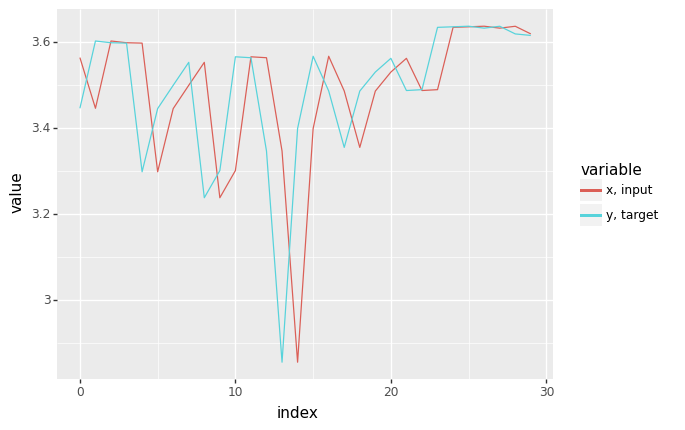

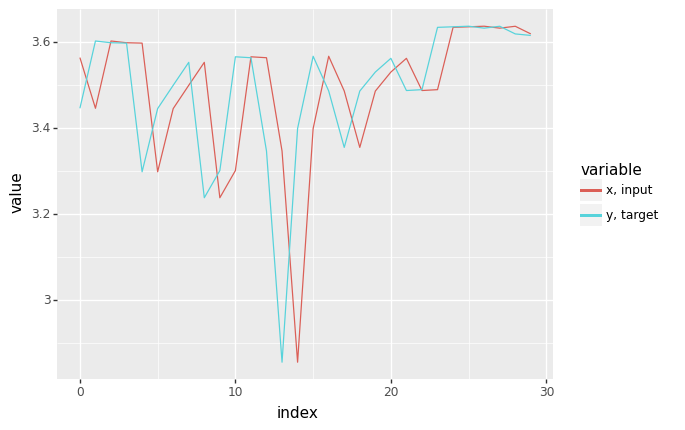

In [7]:
_off = 30
plot = utils.plot_samples(
    truth=expl_batch['target'][0, :_off], 
    prediction=expl_batch['input'][0, :_off],
    truth_label='y, target',
    prediction_label='x, input')
plot.draw()

Glossary of shapes:
B: Batch size.
T: Sequence length aka Time dimension of a time series.
F: Number of features aka model embedding size.
H: Hidden size of a NN.
V: Block size.

In [8]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    model = hk.GRU(HIDDEN_SIZE)
    # model = hk.DeepRNN([
    #     hk.GRU(HIDDEN_SIZE),
    #     jax.nn.relu,
    #     hk.GRU(HIDDEN_SIZE)
    # ])
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

def sequence_loss(batch: Batch, rng_key: jnp.ndarray, t_f_prob: jnp.float32) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    dense = hk.Linear(FEATURE_NUM)
    batch_size, sequence_length, _ = batch['input'].shape  # (B, T, F)

    initial_state = core.initial_state(batch_size)

    _input = batch['input']  # (B, T, F)

    # logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)  # (B, T, HIDDEN_SIZE)
    # logits_batched = hk.BatchApply(hk.Linear(FEATURE_NUM))(logits)  # (B, T, 1)

    def body_fn(t: int, v: LoopValues) -> LoopValues:
        logit = v.logits[:, t, :]  # (B, F)
        new_logit, new_state = core(logit, v.state)  # (B, V)
        new_logit = jnp.reshape(new_logit, (BATCH_SIZE, 1, HIDDEN_SIZE))
        new_logit = hk.BatchApply(dense)(new_logit)
        new_logit = jnp.reshape(new_logit, (BATCH_SIZE, FEATURE_NUM))

        # teacher forcing
        p = v.t_f_p
        _key, _subkey = jax.random.split(v.rng_key)
        t_f_replace = jax.random.choice(_subkey,
                jnp.array([1, 0], dtype=jnp.bool_), p = jnp.array([p, 1-p]))
        t_f_keep = jnp.invert(t_f_replace)

        new_logit = jnp.reshape(new_logit, (BATCH_SIZE, FEATURE_NUM))
        t_f_logit = new_logit*t_f_replace + _input[:, t+1, :]*t_f_keep
        new_logits = v.logits.at[:, t + 1, :].set(t_f_logit)
        return LoopValues(logits=new_logits, state=new_state, rng_key=_key, t_f_p=p)

    output_seq = jnp.zeros((BATCH_SIZE, BLOCK_SIZE, FEATURE_NUM))
    output_seq = output_seq.at[:, 0, :].set(_input[:, 0, :])
    initial_values = LoopValues(logits=output_seq, state=initial_state,
                                rng_key=rng_key, t_f_p=t_f_prob)
    lv: LoopValues = hk.fori_loop(0, BLOCK_SIZE, body_fn, initial_values)

    loss = jnp.mean(jnp.abs(batch['target'] - lv.logits))  # MAE
    return loss

@jax.jit
def update(state: TrainingState, batch: Batch, rng_key: jnp.array) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch, rng_key, state.t_f_p)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state, t_f_p=state.t_f_p)

def generate(context: jnp.ndarray, seq_len: int) -> jnp.array:
    """Draws samples from the model, given an initial context."""
    core = make_network()
    dense = hk.Linear(FEATURE_NUM)

    batch_size, sequence_length, _ = context.shape  # (B, T, F)

    initial_state = core.initial_state(batch_size)

    # _input = jnp.expand_dims(context, -1)  # (B, T, 1)
    _input = jnp.reshape(context, (sequence_length, 1, 1))

    context_outs, _state = hk.dynamic_unroll(core, _input, initial_state)  # (T, 1, V)

    context_outs = hk.BatchApply(dense)(context_outs)

    def body_fn(t: int, v: LoopValues) -> LoopValues:
        logit = v.logits[t]
        new_logit, new_state = core(logit, v.state)  # (1, V)
        new_logit = dense(new_logit)
        new_logits = v.logits.at[t+1].set(new_logit)
        return LoopValues(logits=new_logits, state=new_state, rng_key=jnp.array([]), t_f_p=.0)

    output_seq = jnp.zeros((seq_len - sequence_length, 1, FEATURE_NUM))
    output_seq = output_seq.at[0].set(context_outs[0])
    initial_values = LoopValues(logits=output_seq, state=initial_state, rng_key=jnp.array([]), t_f_p=.0)
    lv: LoopValues = hk.fori_loop(0, seq_len - sequence_length, body_fn, initial_values)
    return jnp.concatenate([context_outs, lv.logits])

In [9]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
loss_fn = jax.jit(loss_fn)
initial_params = init_params_fn(next(rng), expl_batch, next(rng), .0)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state, t_f_p=.10)

In [10]:
def train(state):
    train_loss_all = jnp.array([])
    eval_loss_all = jnp.array([])

    for step in range(NUM_TRAINING_STEPS):
        _key = next(rng)
        train_batch = next(train_di)
        state = update(state, train_batch, _key)

        if step % EVAL_INTERVAL == 0:
            eval_batch = next(train_di)
            train_loss = loss_fn(state.params, train_batch, _key, state.t_f_p)
            eval_loss = loss_fn(state.params, eval_batch, _key, state.t_f_p)
            train_loss_all = jnp.append(train_loss_all, train_loss)
            eval_loss_all = jnp.append(eval_loss_all, eval_loss)
            print({
                'step': step,
                'train_loss': float(train_loss),
                'eval_loss': float(eval_loss),
                'TF': float(state.t_f_p)
            })

            # TF
            state = TrainingState(state.params, state.opt_state, state.t_f_p + .01)

    return state, train_loss_all, eval_loss_all

final_state, train_loss_arr, eval_loss_arr = train(state)

{'step': 0, 'train_loss': 0.31916818022727966, 'eval_loss': 0.3003206253051758, 'TF': 0.10000000149011612}
{'step': 10, 'train_loss': 0.23317795991897583, 'eval_loss': 0.27394136786460876, 'TF': 0.10999999940395355}
{'step': 20, 'train_loss': 0.23548828065395355, 'eval_loss': 0.22135649621486664, 'TF': 0.11999999731779099}
{'step': 30, 'train_loss': 0.18847380578517914, 'eval_loss': 0.22356288135051727, 'TF': 0.12999999523162842}
{'step': 40, 'train_loss': 0.33392733335494995, 'eval_loss': 0.23407867550849915, 'TF': 0.14000000059604645}
{'step': 50, 'train_loss': 0.155795156955719, 'eval_loss': 0.22446377575397491, 'TF': 0.15000000596046448}
{'step': 60, 'train_loss': 0.22417017817497253, 'eval_loss': 0.2281380295753479, 'TF': 0.1600000113248825}
{'step': 70, 'train_loss': 0.2553839087486267, 'eval_loss': 0.38677749037742615, 'TF': 0.17000001668930054}
{'step': 80, 'train_loss': 0.2795817255973816, 'eval_loss': 0.22135446965694427, 'TF': 0.18000002205371857}
{'step': 90, 'train_loss': 

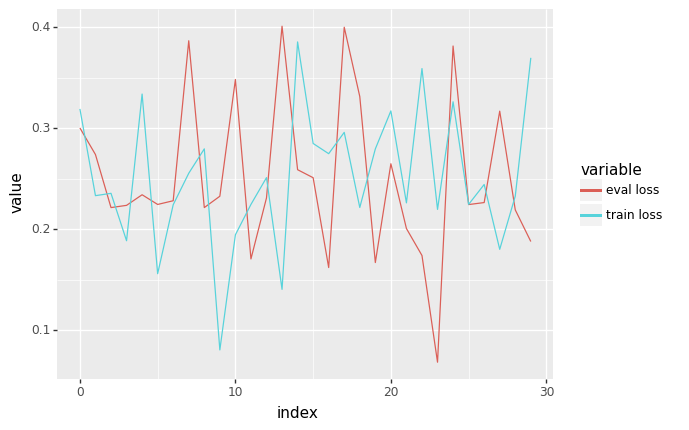

In [11]:
plot = utils.plot_samples(
    truth=train_loss_arr,
    prediction=eval_loss_arr,
    truth_label='train loss',
    prediction_label='eval loss')
plot.draw()

### Generating data from the model

In [12]:
_, generate_fn = hk.without_apply_rng(hk.transform(generate))
predict = jax.jit(generate_fn, static_argnums=2)

In [13]:
val_batch = next(test_di)
context = val_batch["input"][:1, :]
predicted = generate_fn(final_state.params, context, BLOCK_SIZE*2 )

In [14]:
predicted.shape, val_batch["target"].shape

((576, 1, 1), (8, 288, 1))

In [15]:
print(f" MAE: {jnp.mean(jnp.abs(val_batch['target'][0, :, -1] - predicted[:BLOCK_SIZE, -1, -1])):.4f}")
print(f" MSE: {jnp.mean(jnp.square(val_batch['target'][0, :, -1] - predicted[:BLOCK_SIZE, -1, -1])):.4f}")

 MAE: 0.2618
 MSE: 0.2995


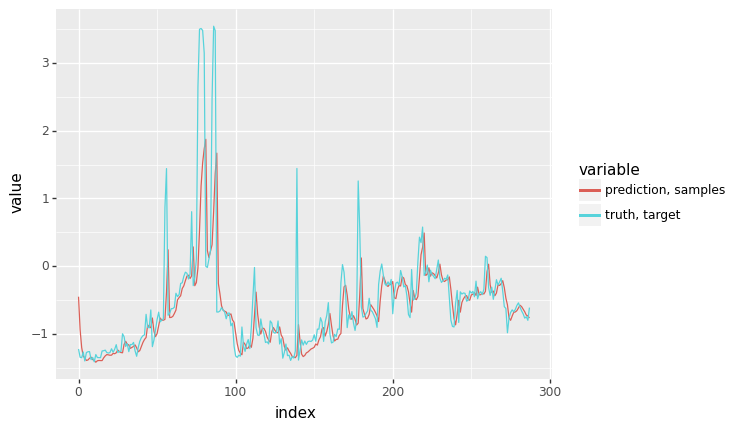

In [16]:
plot = utils.plot_samples(
    val_batch["target"][0, :, -1],
    predicted[:BLOCK_SIZE, -1, -1],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()

### Neighbour error correlation

the goal is:
* run the model over test data for each node;
* collect error (truth - model output) data;
* compose a correlation matrix;
* draw a heatmap of correlations;

notes:
* errors should be calculated using denormalized data;

In [17]:
model_errors = {}
for src, dst in metadata.CONNECTIONS:
    _test_di = dl.get_edge_data_iterator(src, dst, train=False)
    model_errors[(src, dst)] = jnp.array([])
    for _ in range(5):
        test_batch = next(_test_di)
        for bi in range(BATCH_SIZE):
            context = test_batch["input"][bi:bi+1, :]
            predicted = generate_fn(final_state.params, context, BLOCK_SIZE+1)

            denormalized_target = test_batch["target"][bi:bi+1, :]*dl.metadata[(src, dst)]['std'] + \
                              dl.metadata[(src, dst)]['mean']
            denormalized_predictions = predicted*dl.metadata[(src, dst)]['std'] + \
                              dl.metadata[(src, dst)]['mean']
            error = denormalized_target - denormalized_predictions
            model_errors[(src, dst)] = jnp.append(model_errors[(src, dst)], error)

In [18]:
corr_matrix = jnp.zeros((metadata.NUM_EDGES**2, 1))
_map = metadata.NODE_IDS_TO_LABELS_MAPPING
x = 0
for a in metadata.CONNECTIONS:
    for b in metadata.CONNECTIONS:
        if a == b:
            _corr = .0
        else:
            _corr = jnp.corrcoef(model_errors[a], model_errors[b])[0, 1]
        corr_matrix = corr_matrix.at[x].set(_corr)
        x += 1

corr_matrix = corr_matrix.reshape((metadata.NUM_EDGES, metadata.NUM_EDGES))

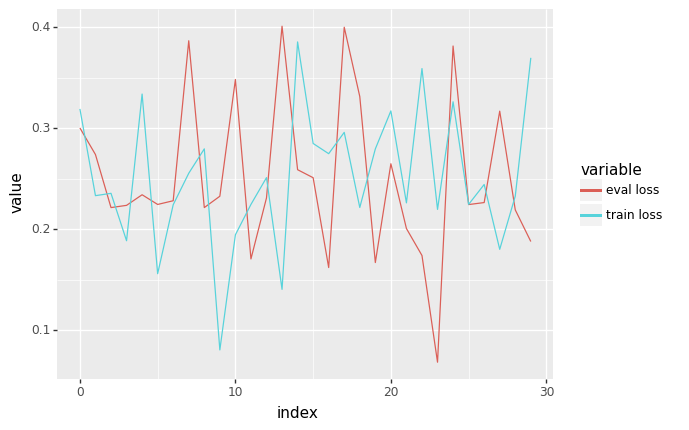

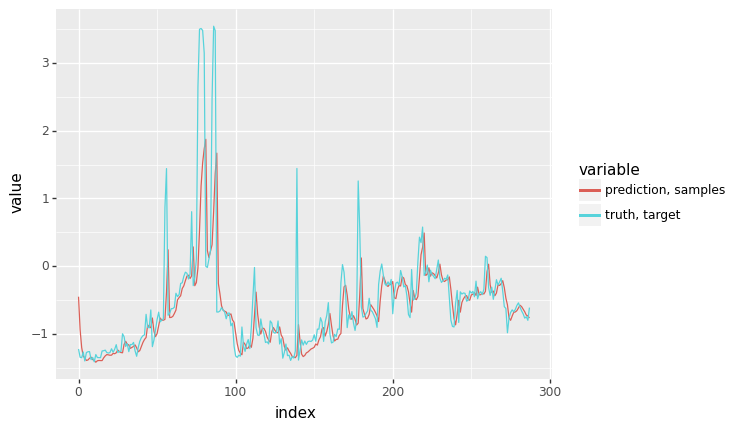

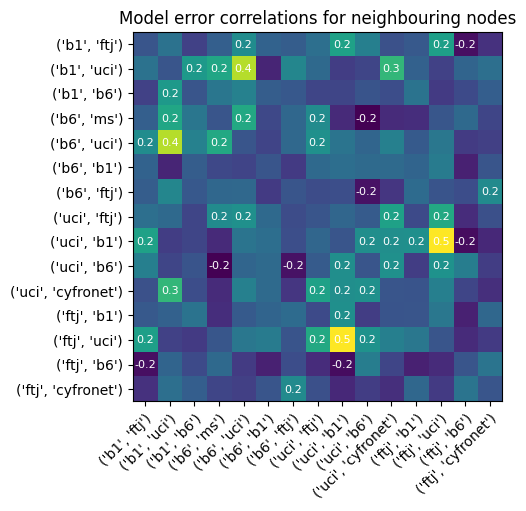

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)

ax.set_xticks(jnp.arange(len(metadata.CONNECTIONS)), labels=metadata.CONNECTIONS)
ax.set_yticks(jnp.arange(len(metadata.CONNECTIONS)), labels=metadata.CONNECTIONS)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# create text annotations
for i in range(metadata.NUM_EDGES):
    for j in range(metadata.NUM_EDGES):
        # we're not interested in correlations below 0.15
        lb = "" if -.15 < corr_matrix[i, j] < .15 else f"{corr_matrix[i, j]:.1f}"
        text = ax.text(j, i, lb, ha="center", va="center", color="w", size=8)

ax.set_title("Model error correlations for neighbouring nodes")
plt.show()

In [20]:
a = jnp.corrcoef(model_errors[('b1', 'ftj')], model_errors[('b1', 'uci')])
b = jnp.corrcoef(model_errors[('b1', 'ftj')], model_errors[('uci', 'cyfronet')])
a, b

(Array([[1.        , 0.07864621],
        [0.07864621, 1.        ]], dtype=float32),
 Array([[ 1.        , -0.01080991],
        [-0.01080991,  0.99999994]], dtype=float32))

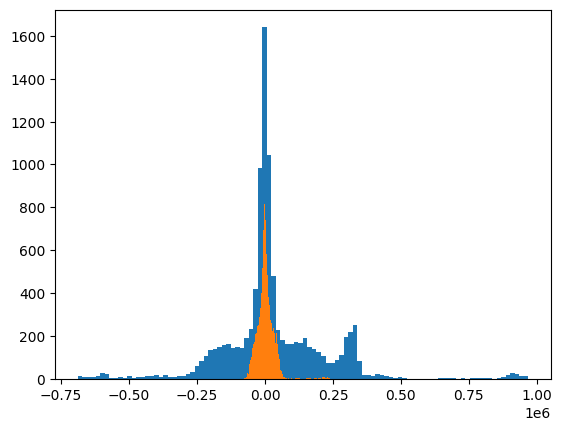

In [21]:
plt.figure()
plt.hist(jax.random.choice(jax.random.PRNGKey(SEED), model_errors[('b1', 'ftj')], (10000, )), bins=100)
plt.hist(jax.random.choice(jax.random.PRNGKey(SEED), model_errors[('ftj', 'cyfronet')], (10000, )), bins=100)
plt.show()

### Autoregressive predictions - it generally sucks

In [22]:
val_batch = next(test_di)
context = val_batch["input"][:1, :BLOCK_SIZE // 2]
predicted = generate_fn(final_state.params, context, BLOCK_SIZE)  # (T, B, F)
predicted.shape

(288, 1, 1)

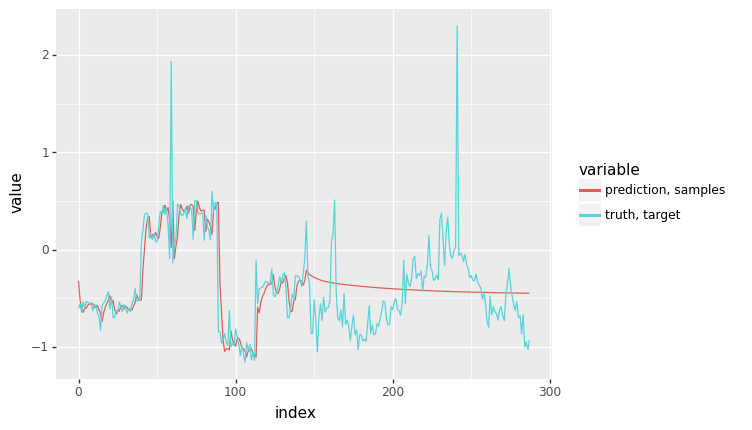

In [23]:
plot = utils.plot_samples(
    val_batch["target"][0],
    predicted[:, -1:, -1],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()